## Library Imports , Setting seeds(Reproducibility) and GPU checks

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchinfo import summary
import torch.nn as nn
from math import sqrt
import pandas as pd
import numpy as np
import random
import torch
import os

# Setting up Seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Using GPU if available
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


## Loading Data

In [7]:

# Removing Samples where data had to be discarded due to some collection errors.

remove = ['P1', 'P11','P2', 'P22', 'P25','P3','P37', 'P4', 'P47', 'P48', 'P49','P50', 'P54', 'P56', 'P59','P16', 'P24', 'P67', 'P68', 'P72','P74','P75','P30','P51','P58']

dataset = np.load('Dataset_OneD_CNN.npy',allow_pickle=True)
dataset = dataset[~np.isin(dataset[:,0],remove)]
# dataset = dataset[np.isin(dataset[:,0],Needed)]

X = pd.DataFrame(dataset[:,1:-3], dtype=float)
X = torch.tensor(X.values, dtype=torch.float)
X = torch.unsqueeze(X, dim=1)

y_FEV1 = pd.DataFrame(dataset[:,-2], dtype=float)
y_FEV1 = torch.tensor(y_FEV1.values, dtype=torch.float)

y_FVC = pd.DataFrame(dataset[:,-1], dtype=float)
y_FVC = torch.tensor(y_FVC.values, dtype=torch.float)

print(X.shape,y_FEV1.shape,y_FVC.shape)

torch.Size([46, 1, 48000]) torch.Size([46, 1]) torch.Size([46, 1])


## OneD_CNN Model

In [8]:
class OneD_Cnn(nn.Module):

  def __init__(self,input_size=48000,batch_size=4,output_size=1,Conv=[32,32,32,32],FClayers=[64,32,32,16]):
    super().__init__()

    # initialize the CNN layers and the Batch Normalization layers
    self.conv1 = nn.Conv1d(1, Conv[0], kernel_size=3, stride=1, padding=1,dtype=torch.float)
    self.bn1 = nn.BatchNorm1d(Conv[0],dtype=torch.float)
    self.conv2 = nn.Conv1d(Conv[0], Conv[1], kernel_size=3, stride=1, padding=1,dtype=torch.float)
    self.bn2 = nn.BatchNorm1d(Conv[1],dtype=torch.float)
    self.conv3 = nn.Conv1d(Conv[1], Conv[2], kernel_size=3, stride=1, padding=1,dtype=torch.float)
    self.bn3 = nn.BatchNorm1d(Conv[2],dtype=torch.float)
    self.conv4 = nn.Conv1d(Conv[2], Conv[3], kernel_size=3, stride=1, padding=1,dtype=torch.float)
    self.bn4 = nn.BatchNorm1d(Conv[3],dtype=torch.float)

    self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    self.relu = nn.ReLU()

    # initialize the FC layers
    self.fc1 = nn.Linear((input_size//16)*Conv[-1], FClayers[0],dtype=torch.float)
    torch.nn.init.uniform_(self.fc1.weight,-sqrt(6/input_size), sqrt(6/input_size))

    self.fc2 = nn.Linear(FClayers[0], FClayers[1],dtype=torch.float)
    torch.nn.init.uniform_(self.fc2.weight,-sqrt(6/FClayers[0]), sqrt(6/FClayers[0]))

    self.fc3 = nn.Linear(FClayers[1], FClayers[2],dtype=torch.float)
    torch.nn.init.uniform_(self.fc3.weight,-sqrt(6/FClayers[1]), sqrt(6/FClayers[1]))

    self.fc4 = nn.Linear(FClayers[2], FClayers[3],dtype=torch.float)
    torch.nn.init.uniform_(self.fc4.weight,-sqrt(6/FClayers[2]), sqrt(6/FClayers[2]))

    self.fc5 = nn.Linear(FClayers[3], output_size,dtype=torch.float)
    torch.nn.init.uniform_(self.fc5.weight,-sqrt(6/FClayers[3]), sqrt(6/FClayers[3]))



  def forward(self,x):

    # first Conv layer
    x = self.conv1(x)
    x = self.relu(self.bn1(x))
    # x= 10*torch.sin(self.bn1(x)) 
    x = self.pool(x)

    # second Conv layer
    x = self.conv2(x)
    x = self.relu(self.bn2(x))
    # x= 10*torch.sin(self.bn2(x))
    x = self.pool(x)

    # third Conv layer
    x = self.conv3(x)
    x = self.relu(self.bn3(x))
    # x= 10*torch.sin(self.bn3(x))
    x = self.pool(x)

    # fourth Conv layer
    x = self.conv4(x)
    x = self.relu(self.bn4(x))
    # x= 10*torch.sin(self.bn4(x))
    x = self.pool(x)

    # flatten the x
    x = x.view(x.size(0), -1)

    # FC layers
    x = self.fc1(x)
    x = torch.sin(30*x)

    x = self.fc2(x)
    x = torch.sin(30*x)
    
    x = self.fc3(x)
    x = torch.sin(30*x)

    x = self.fc4(x)
    x = torch.sin(30*x)

    x = self.fc5(x)
    return x

model = OneD_Cnn()
# print(model)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
summary(model, input_size=(1,1,48000),dtypes=[torch.float])

Layer (type:depth-idx)                   Output Shape              Param #
OneD_Cnn                                 [1, 1]                    --
├─Conv1d: 1-1                            [1, 32, 48000]            128
├─BatchNorm1d: 1-2                       [1, 32, 48000]            64
├─ReLU: 1-3                              [1, 32, 48000]            --
├─MaxPool1d: 1-4                         [1, 32, 24000]            --
├─Conv1d: 1-5                            [1, 32, 24000]            3,104
├─BatchNorm1d: 1-6                       [1, 32, 24000]            64
├─ReLU: 1-7                              [1, 32, 24000]            --
├─MaxPool1d: 1-8                         [1, 32, 12000]            --
├─Conv1d: 1-9                            [1, 32, 12000]            3,104
├─BatchNorm1d: 1-10                      [1, 32, 12000]            64
├─ReLU: 1-11                             [1, 32, 12000]            --
├─MaxPool1d: 1-12                        [1, 32, 6000]             --
├─Conv1d

## Trainier Function

In [9]:
def LOOCV_OneD_Cnn(OneD_Cnn,X,y,num_epochs= 100,batch_size = 5):

    print("Training of 1D CNN Started (LOOCV)")

    loo     = LeaveOneOut()
    prog    = 0
    tot     = len(X)
    y_GT    = []
    y_PT    = []
    

    for i,(train_index, test_index) in enumerate(loo.split(X)):

        prog = prog + 1

        X_Train, X_Test = X[train_index],X[test_index]
        y_Train, y_Test = y[train_index],y[test_index]

        model = OneD_Cnn(batch_size=batch_size).to(device)
        criterion = nn.SmoothL1Loss()
        optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

        train_dataset = DataLoader(list(zip(X_Train,y_Train)), shuffle=True, batch_size=batch_size)
        test_dataset = DataLoader(list(zip(X_Test,y_Test)), shuffle=True, batch_size=1)

        for epochs in range(num_epochs):
            i=0
            for data,target in train_dataset:
                i=i+1
                print("Fold : {0}/{1} \t Epoch : {2}/{3} \t Batch : {4}/{5}                             ".format(prog,tot,epochs+1,num_epochs,i,len(train_dataset)),end='\r')
                data,target = data.to(device),target.to(device)
                out = model(data)
                loss = criterion(out.reshape(1,-1), target.reshape(1,-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        print()
            
        for data,target in test_dataset:
                y_GT.append(target.cpu().detach().numpy().ravel())
                out = model(data.to(device))
                y_PT.append(out.cpu().detach().numpy().ravel())


    print("Training Completed \n")

    print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
    print("MLP metrics : ")
    print("\tMean Absolute Percentage Error : " , 100 * mean_absolute_percentage_error(y_GT,y_PT))
    print("\tMean Aabsolute Error : " , mean_absolute_error(y_GT,y_PT))
    print("\tMean Square Error : " , mean_squared_error(y_GT,y_PT,squared=False))
    print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")

    return np.array(y_GT).ravel(),np.array(y_PT).ravel()

## Training 1D CNN model for estimating FEV1

In [10]:
y_GT_FEV1,y_PT_FEV1=LOOCV_OneD_Cnn(OneD_Cnn,X,y_FEV1,num_epochs=50,batch_size = 5)

Training of 1D CNN Started (LOOCV)
Fold : 1/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 2/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 3/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 4/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 5/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 6/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 7/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 8/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 9/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 10/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 11/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 12/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 13/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 14/46 	 Epoch : 50/50 	 Batch :

## Training 1D CNN model for estimating FVC

In [11]:
y_GT_FVC,y_PT_FVC=LOOCV_OneD_Cnn(OneD_Cnn,X,y_FVC,num_epochs=50,batch_size = 5)

Training of 1D CNN Started (LOOCV)
Fold : 1/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 2/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 3/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 4/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 5/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 6/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 7/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 8/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 9/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 10/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 11/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 12/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 13/46 	 Epoch : 50/50 	 Batch : 9/9                             
Fold : 14/46 	 Epoch : 50/50 	 Batch :

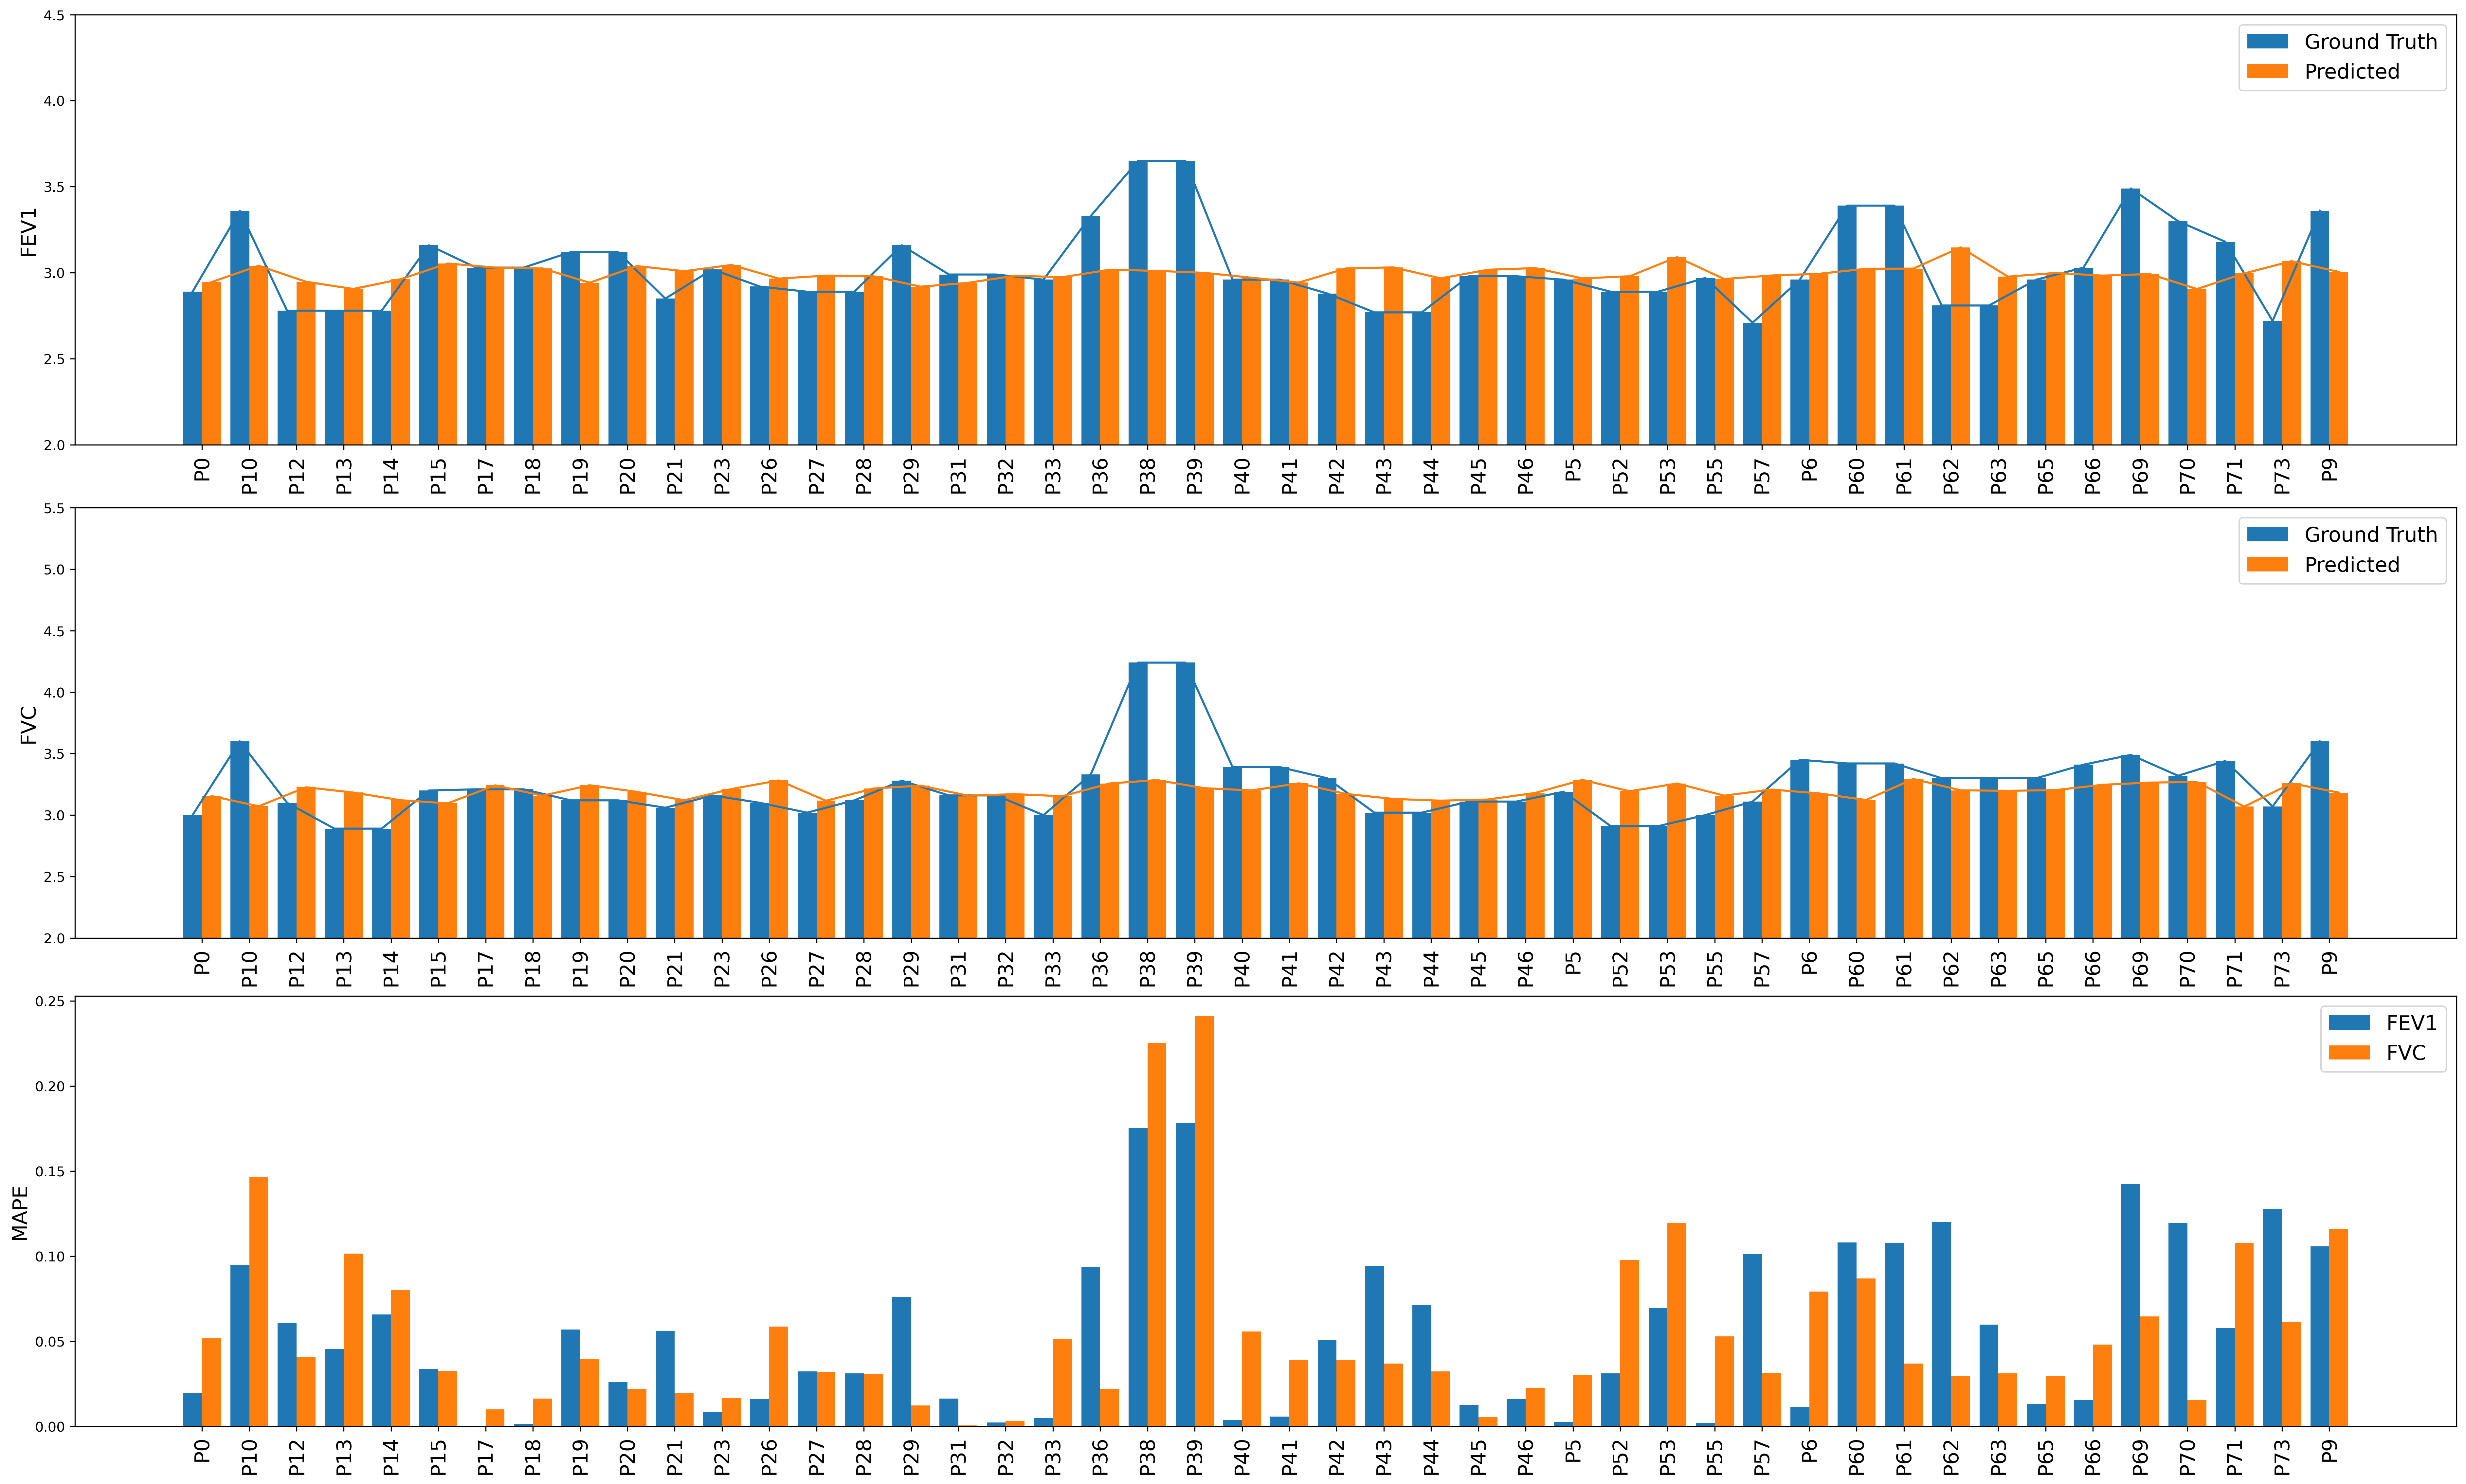

In [12]:
# Plotting ground truth vs predicted values for FEV1
plt.figure(figsize=(25,15),dpi=300,layout='constrained')
ax1 = plt.subplot(3,1,1)
ax1.bar([i-0.2 for i in range(len(y_GT_FEV1))],y_GT_FEV1,label='Ground Truth',width=0.4)
ax1.plot([i-0.2 for i in range(len(y_GT_FEV1))],y_GT_FEV1)
ax1.bar([i+0.2 for i in range(len(y_PT_FEV1))],y_PT_FEV1,label='Predicted',width=0.4)
ax1.plot([i+0.2 for i in range(len(y_PT_FEV1))],y_PT_FEV1)
ax1.set_xticks([i for i in range(len(y_PT_FEV1))],[dataset[i][0] for i in range(len(y_PT_FEV1))],rotation=90,fontsize=15)
ax1.set_ylim(2,4.5)
# ax1.set_title('FEV1',fontsize=15)
# ax1.set_xlabel('Patient ID',fontsize=15)
ax1.set_ylabel('FEV1',fontsize=15)
ax1.legend(fontsize=15)   

# Plotting ground truth vs predicted values for FVC
ax2 = plt.subplot(3,1,2,sharex=ax1)
ax2.bar([i-0.2 for i in range(len(y_GT_FVC))],y_GT_FVC,label='Ground Truth',width=0.4)
ax2.plot([i-0.2 for i in range(len(y_GT_FVC))],y_GT_FVC)
ax2.bar([i+0.2 for i in range(len(y_PT_FVC))],y_PT_FVC,label='Predicted',width=0.4)
ax2.plot([i+0.2 for i in range(len(y_PT_FVC))],y_PT_FVC)
ax2.set_xticks([i for i in range(len(y_PT_FVC))],[dataset[i][0] for i in range(len(y_PT_FVC))],rotation=90,fontsize=15)
ax2.set_ylim(2,5.5)
# ax2.set_title('FVC',fontsize=15)
# ax2.set_xlabel('Patient ID',fontsize=15)
ax2.set_ylabel('FVC',fontsize=15)
ax2.legend(fontsize=15)


y_FEV1_err = np.abs(y_GT_FEV1-y_PT_FEV1)/y_GT_FEV1
y_FVC_err = np.abs(y_GT_FVC-y_PT_FVC)/y_GT_FVC
ax3 = plt.subplot(3,1,3,sharex=ax2)
ax3.bar([i-0.2 for i in range(len(y_FEV1_err))],y_FEV1_err,label='FEV1',width=0.4)
ax3.bar([i+0.2 for i in range(len(y_FVC_err))],y_FVC_err,label='FVC',width=0.4)
ax3.set_xticks([i for i in range(len(y_PT_FVC))],[dataset[i][0] for i in range(len(y_PT_FVC))],rotation=90,fontsize=15)
# ax3.set_title('MAPE',fontsize=15)
# ax3.set_xlabel('Patient ID',fontsize=15)
ax3.set_ylabel('MAPE',fontsize=15)
ax3.legend(fontsize=15)
plt.show()